In [15]:
import os 
import numpy as np
import pandas as pd
import numpy as np

from classes.matlab_reader import matlab_reader
from classes.grid_funcs import map_grid,dataset,data_wizard
from dotenv import load_dotenv   #for python-dotenv method
from datetime import datetime

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

# ==============================================================================
# Use the cartopy environment for these graphs
# ==============================================================================

from datetime import datetime, timedelta

def get_day_array(date_string = "2018-02-11", days = 9):
    date = datetime.strptime(date_string, "%Y-%m-%d")
    dates = []
    for i in range(days):
        previous_date = date - timedelta(days=i+1)
        dates.append(previous_date.strftime("%Y-%m-%d")) 
    dates.reverse()
    return dates

In [16]:
# Get Temperature Data]
def generate_dataset(path='/Users/joaojesus/Desktop/final_year_proj/PROCESSED_ERA5_ONLINE/COMPRESSED/WIND_EASTWARD/',
                    geo_filtering = {'min_lat':60,'max_lat':80,'min_lon':-180, 'max_lon': 180},
                    year_selection = '1995',
                    data_name = 'wind_eastward'):
    
    grid = map_grid(grid_size=None, source = 'era5')
    wizard = data_wizard()
    res_mean = []
    res_mean_selection = []
    file_names = []
    files = os.listdir(path)
    files.sort()
    for file in files:
        if file[:4] == year_selection:
            temperature = np.load(path + file)['arr_0']

            select_area_indexer = grid.select_area_indexer(
                min_lat= geo_filtering['min_lat'],
                max_lat= geo_filtering['max_lat'],
                min_lon= geo_filtering['min_lon'],
                max_lon= geo_filtering['max_lat'])

            data = wizard.data_filtering(select_area_indexer = select_area_indexer ,data = temperature)

            file_names.append(file[:10])
            res_mean.append(np.nanmean(temperature))
            res_mean_selection.append(np.nanmean(data))

    df = pd.DataFrame(data={
        'dates' : file_names,
        f'{data_name}_mean' : res_mean,
        f'{data_name}_mean_selection' : res_mean_selection
    })
    
    df['dates'] = pd.to_datetime(df['dates'])
    df = df.sort_values(by='dates')
    df = df.reset_index()
    df = df.drop(columns=['index'])

    return df

def find_ssw(df):
    values = df['wind_eastward_mean_cos'].to_list()
    SSW_ = [False]

    for i in range(1,len(values)):
        if values[i-1] >= 0 and values[i] < 0:
            SSW_.append(True)
        else:
            SSW_.append(False)

    df['SSW_'] = SSW_
    df['SSW_flag'] = False

    day_threshold = 1
    for index in df[df['SSW_'] == True].index:
        if len(df.iloc[index:index+day_threshold].loc[df['wind_eastward_mean_cos'] < 0]) >= day_threshold :
            df['SSW_flag'].iloc[index] = True
    return df
    

In [17]:
flag = True
if flag:
        
    df_all  = pd.DataFrame()
    for year in range(2017,2019+1):
        YEAR = year

        df_wind = generate_dataset(path='/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/',
                            geo_filtering = {'min_lat':59,'max_lat':61,'min_lon':-180, 'max_lon': 180},
                            year_selection = f'{YEAR}',
                            data_name = 'wind_eastward')

        df_temperature = generate_dataset(path='/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/TEMPERATURE/',
                            geo_filtering = {'min_lat':60,'max_lat':90,'min_lon':-180, 'max_lon': 180},
                            year_selection = f'{YEAR}',
                            data_name = 'temperature')

        df = pd.merge(df_wind,df_temperature[['dates','temperature_mean_selection']],how='left', on='dates')
        
        df['wind_eastward_mean_cos'] = df['wind_eastward_mean'] * np.cos(np.deg2rad(60))
        df = find_ssw(df)

        index = df.index[df['SSW_flag'] == True].tolist()
        
        df_all = pd.concat([df_all,df])

KeyboardInterrupt: 

In [ ]:
# # save all

# df = df_all
# df = df.reset_index()
# df = df.drop(columns = ['index'])
# index = df.index[df['SSW_flag'] == True].tolist()

# SAVE_SSW_EVENT = True
# if SAVE_SSW_EVENT:
#     if len(index) > 0:
#         for index in index:
#             try: 

#                 day_window = 45
#                 df_dataset = df.loc[index-day_window:index+day_window]
#                 df_dataset['t_delta'] = [i for i in range(-day_window,day_window+1)]
#                 date_str = df.loc[index]['dates'].strftime("%Y-%m-%d")
#                 df_dataset = df_dataset.reset_index()
#                 df_dataset= df_dataset.drop(columns=['index'])
#                 df_dataset = df_dataset.drop(columns=['SSW_'])
                
#                 df_dataset.to_csv(f'ssw_events_saved/{date_str}_ssw.csv', sep=',',index=False)
#             except:
#                 print('error')
#                 pass



In [ ]:
# import shutil
# import os

# source_folder = "ssw_events_saved"
# dest_folder = "ssw_events_saved_filtered"
# dest_folder_2 = "ssw_events_saved_filtered_2"

# for filename in os.listdir(source_folder):
#     source_path = os.path.join(source_folder, filename)
#     dest_path = os.path.join(dest_folder, filename)
#     if os.path.isfile(source_path) and os.path.exists(dest_path):
#         shutil.copy(source_path, dest_folder_2)

In [ ]:
import plotly.graph_objects as go

# Create figure and plot the DataFrame
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['dates'], y=df['wind_eastward_mean_cos'], name='ZMZW', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df['dates'], y=df['temperature_mean_selection'], name='Mean Temperature', line=dict(color='orange'), yaxis='y2'))


# Add a dashed line at y=0
fig.add_shape(type='line', x0=df['dates'].min(), y0=0, x1=df['dates'].max(), y1=0, line=dict(color='gray', dash='dash'))

# Find the index of the first negative value
first_negative_index = (df['wind_eastward_mean_cos'] < 0).idxmin()

# Add vertical lines for SSW_flag == True
for i, row in df.iterrows():
    if row.SSW_flag == True:
        fig.add_shape(type='line', x0=row.dates, y0=-50, x1=row.dates, y1=50, line=dict(color='red', dash='dash'))

# Set layout
fig.update_layout(
    yaxis=dict(
        range=[-50, 80],
        title='ZMZW at 60◦ N latitude (m/s)'
    )
    ,yaxis2=dict(
        range=[190, 250],
        title='Zonal Temperature at 60◦ N to 90◦ N (k)',
        side='right',
        overlaying='y'
    )
    ,xaxis=dict(title='Dates'),
    # title=f'ZMZW at 60◦ N latitude in {YEAR}',
    title=f'SSW Event between 2018 and 2019',
    legend=dict(orientation="h", y=1.2, x=0.5),
    # Set the background color to white
    plot_bgcolor='white',
    # Set the grid color to grey
    xaxis_gridcolor='lightgray',
    yaxis_gridcolor='lightgray'
)

# Show the plot
fig.show()


In [ ]:
df

,dates,wind_eastward_mean,wind_eastward_mean_selection,temperature_mean_selection,wind_eastward_mean_cos,SSW_,SSW_flag
0,2019-01-01,-8.932041,29.008160,248.372241,-4.466021,False,False
1,2019-01-02,-9.945076,24.937564,240.910647,-4.972538,False,False
2,2019-01-03,-11.228515,21.147963,237.547114,-5.614258,False,False
3,2019-01-04,-12.865793,16.881719,236.031983,-6.432896,False,False
4,2019-01-05,-12.484472,17.841786,234.140289,-6.242236,False,False
...,...,...,...,...,...,...,...
360,2019-12-27,33.498981,94.342294,208.984828,16.749491,False,False
361,2019-12-28,33.043597,92.334088,211.000657,16.521798,False,False
362,2019-12-29,34.000667,90.041403,207.128472,17.000334,False,False
363,2019-12-30,35.256873,89.583573,204.472995,17.628436,False,False


In [ ]:
df = df_all[(df_all['dates'] > '2018-12-01') & (df_all['dates'] < '2019-01-30')]


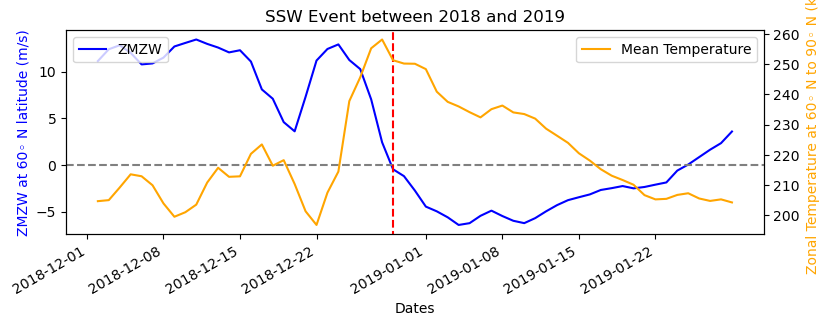

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax1 = plt.subplots(figsize=(9, 3))

ax1.plot(df['dates'], df['wind_eastward_mean_cos'], color='blue', label='ZMZW')
ax1.set_ylabel('ZMZW at 60◦ N latitude (m/s)', color='blue')

ax2 = ax1.twinx()
ax2.plot(df['dates'], df['temperature_mean_selection'], color='orange', label='Mean Temperature')
ax2.set_ylabel('Zonal Temperature at 60◦ N to 90◦ N (k)', color='orange')

ax1.axhline(y=0, color='gray', linestyle='--')

first_negative_index = (df['wind_eastward_mean_cos'] < 0).idxmin()

for i, row in df.iterrows():
    if row.SSW_flag == True:
        ax1.axvline(x=row.dates, ymin=-50, ymax=50, color='red', linestyle='--')

ax1.set_xlabel('Dates')
ax1.set_title('SSW Event between 2018 and 2019')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.gcf().autofmt_xdate()


plt.show()

In [ ]:
# load era5 data

grid = map_grid(grid_size=None, source = 'era5_online')
wizard = data_wizard()

data_u = np.load('/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/2002-03-16.npz')['arr_0']
data_v= np.load('/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/2002-03-16.npz')['arr_0']


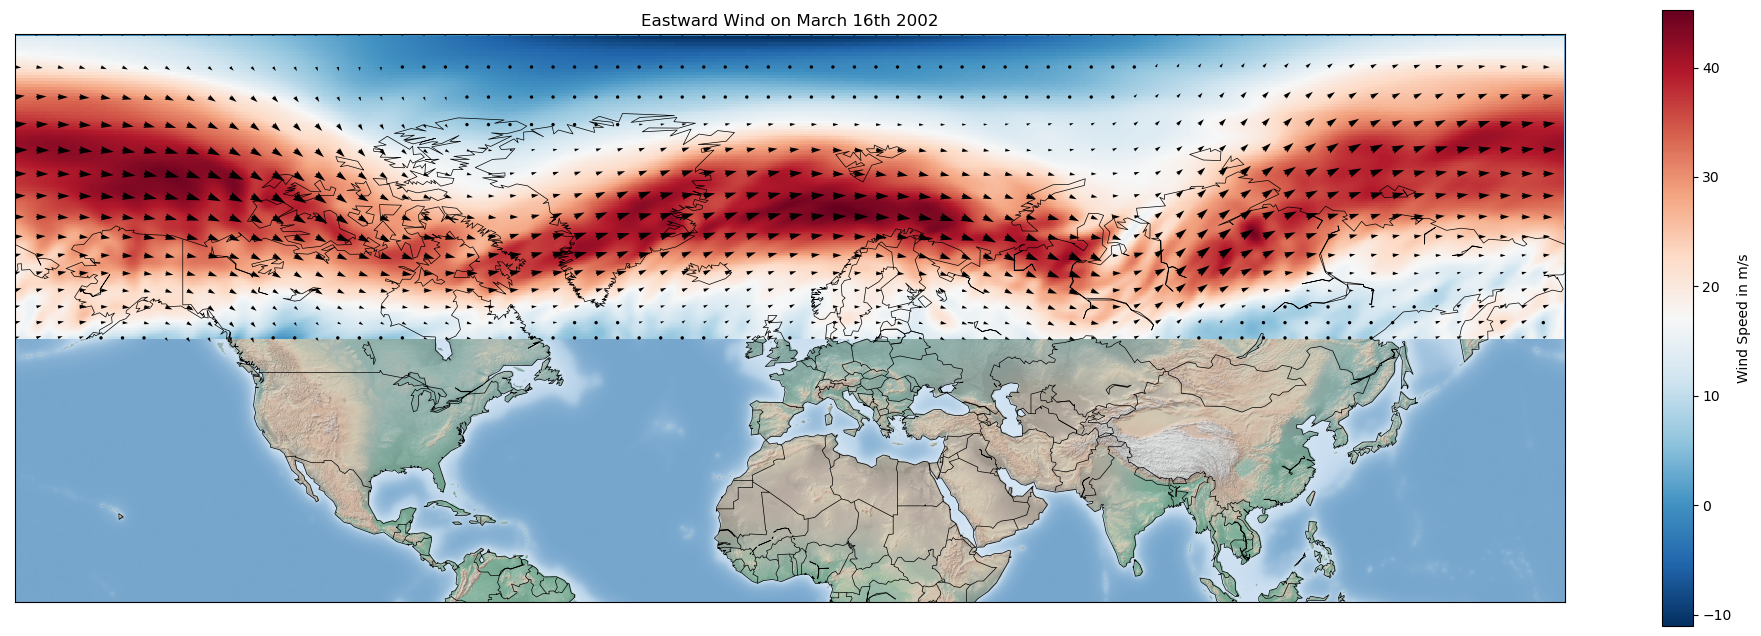

In [ ]:
# =============================================
# plot a single day on a colour mesh and quiver
# =============================================

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(25, 8))

# use to plot north pole stero plot
# plot sterographic projection
# m = Basemap(projection='npstere',boundinglat=0,lon_0=0,resolution='c')

# plot miller projection
m = Basemap(projection='mill',
            llcrnrlat = 0,
            urcrnrlat = 90,
            llcrnrlon = -180,
            urcrnrlon =180)

m.shadedrelief(scale=0.5)

m.pcolormesh(grid.grid_[0], 
             grid.grid_[1], 
             data_u,
             latlon=True, cmap='RdBu_r',
             shading='auto')

x = grid.grid_[0][::10, ::20]
y = grid.grid_[1][::10, ::20]

data_u_d = data_u[::10, ::20]
data_v_d = data_v[::10, ::20]


m.quiver(x, y, 
     data_u_d, data_v_d,scale = 5000,latlon=True)


m.drawcoastlines(linewidth=0.5,linestyle='solid')
m.drawcountries(linewidth=0.5, linestyle='solid',color='k')

# change density of arrows

# plt.title('Eastward Wind on March 16th 2002')
plt.title('Eastward Wind on March 16th 2002')
plt.colorbar(label='Wind Speed in m/s')

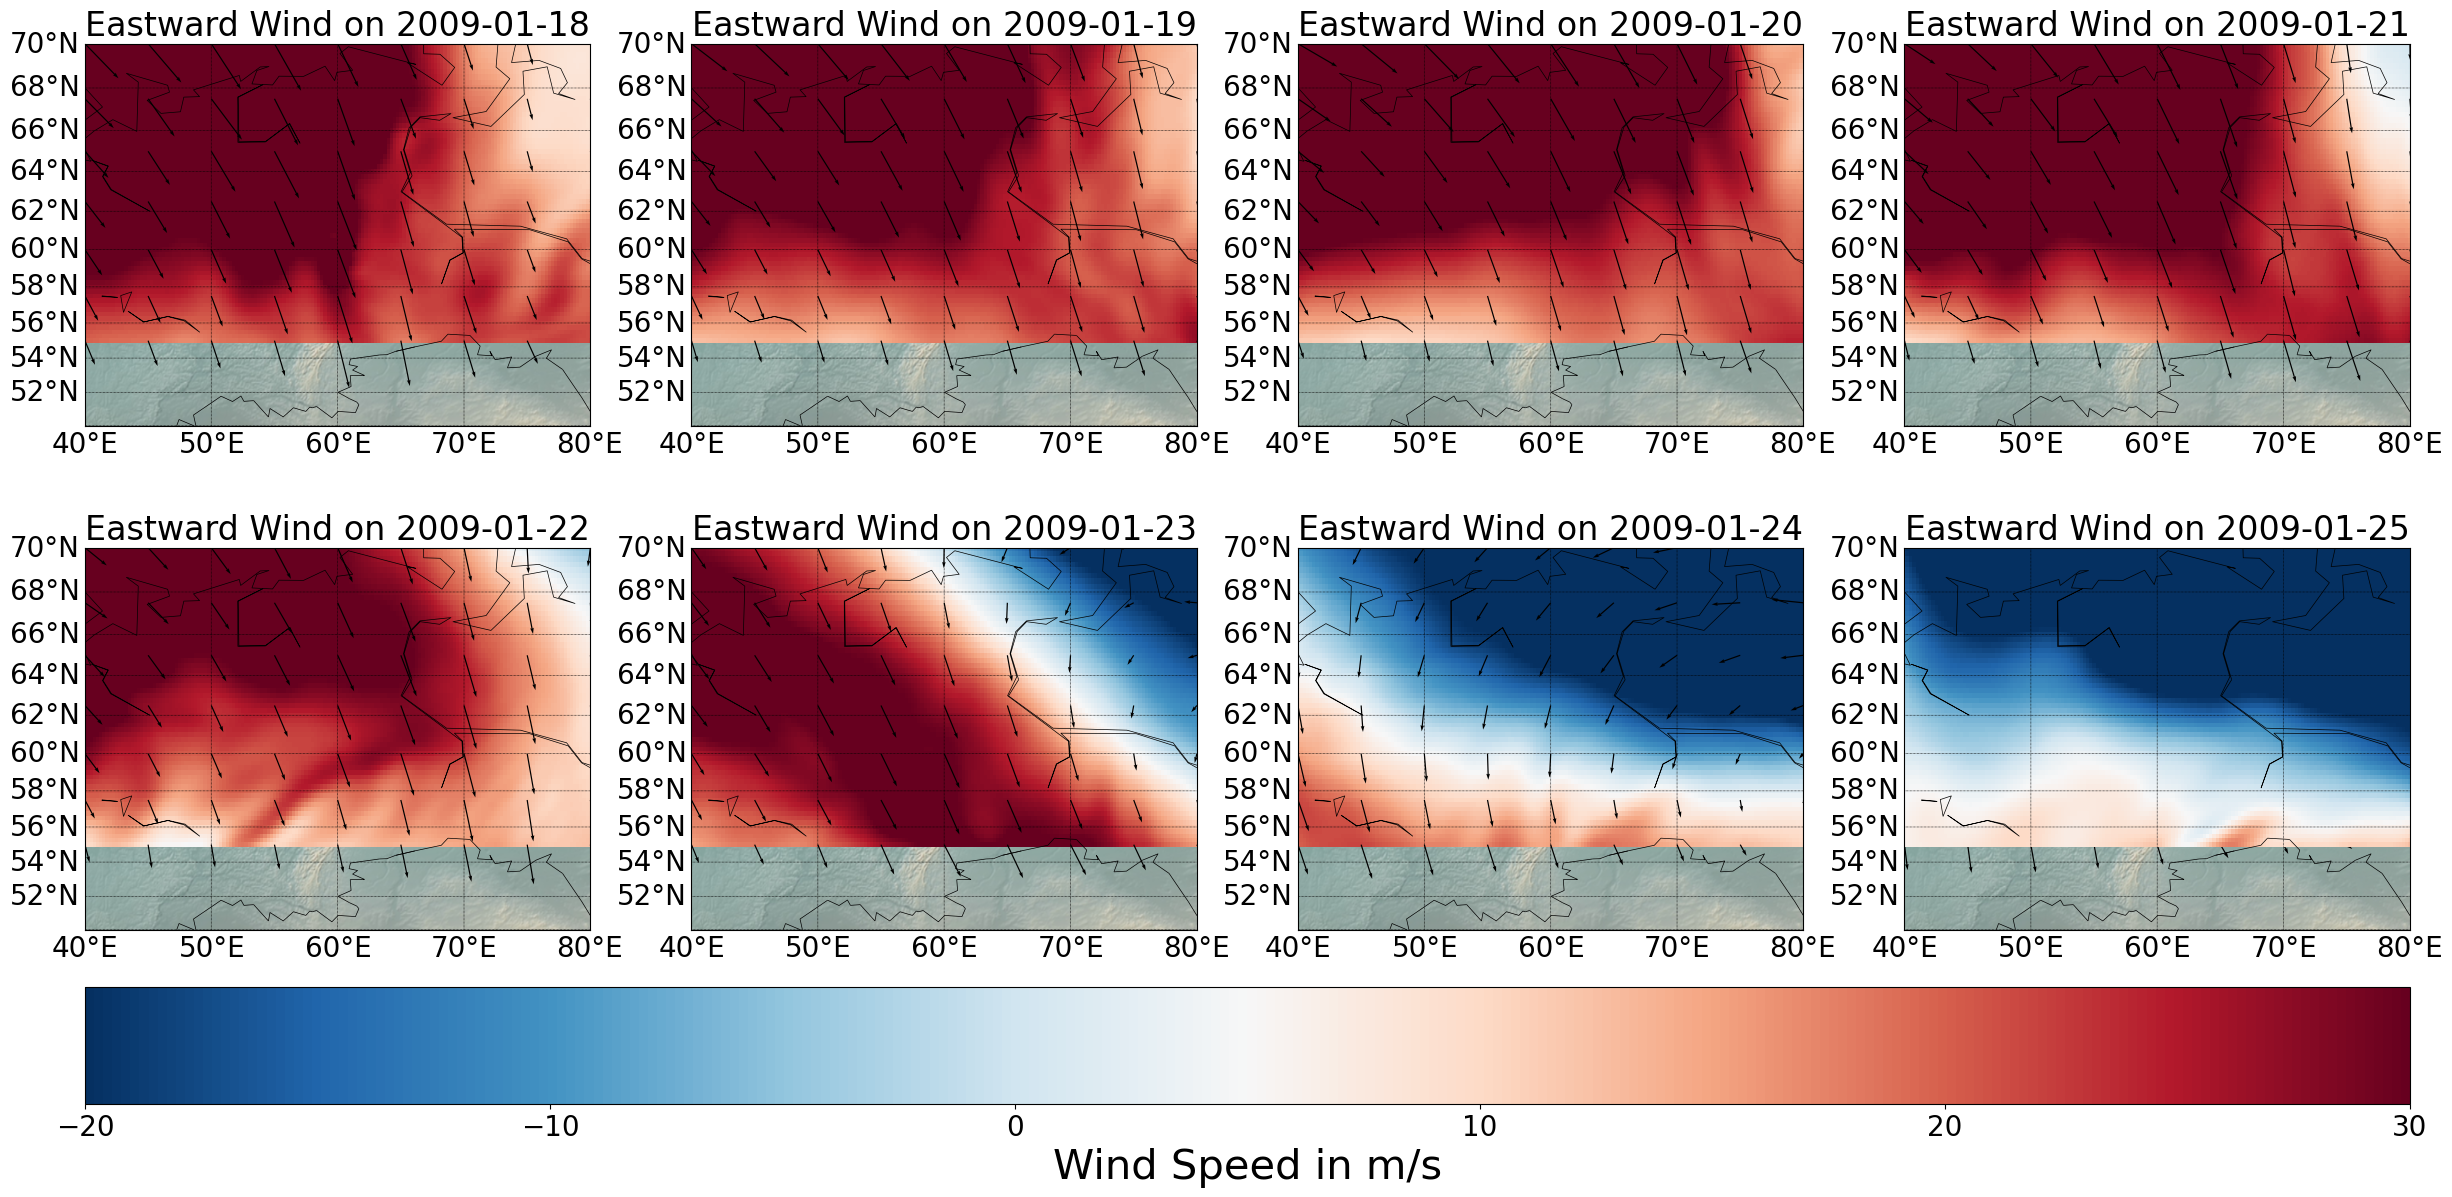

In [40]:
# =============================================
# plot a multiple days on a colour mesh and quiver
# =============================================
# load era5 data

grid = map_grid(grid_size=None, source = 'era5_online')
wizard = data_wizard()

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

days = 8
dates = get_day_array(date_string="2009-01-26",days=days)


data_dict = {}

for i in range(days):
    data_u = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{dates[i]}.npz')['arr_0']
    data_v = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_NORTHWARD/{dates[i]}.npz')['arr_0']
    data_dict[f"data_u_{i+1}"] = data_u
    data_dict[f"data_v_{i+1}"] = data_v


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 15))

data_i = 1

vmin = -20
vmax = 30
for i in range(2):
    for j in range(4):

        data_u = data_dict[f'data_u_{data_i}']
        data_v = data_dict[f'data_v_{data_i}']

        ax = axes[i, j]

        llcrnrlat = 50
        urcrnrlat = 70
        llcrnrlon = 40
        urcrnrlon = 80

        m = Basemap(projection='mill',
                    llcrnrlat = llcrnrlat,
                    urcrnrlat = urcrnrlat,
                    llcrnrlon = llcrnrlon,
                    urcrnrlon = urcrnrlon,
                    ax=ax)

        m.shadedrelief(scale=0.5)

        m.pcolormesh(grid.grid_[0], 
                     grid.grid_[1], 
                     data_u,
                     vmin = vmin,
                     vmax = vmax,
                     latlon=True, cmap='RdBu_r',
                     shading='auto')

        x = grid.grid_[0][::10, ::20]
        y = grid.grid_[1][::10, ::20]

        data_u_d = data_u[::10, ::20]
        data_v_d = data_v[::10, ::20]

        m.quiver(x, y, 
             data_u_d, data_v_d,scale = 1000,latlon=True)

        m.drawcoastlines(linewidth=0.5,linestyle='solid')
        m.drawcountries(linewidth=0.5, linestyle='solid',color='k')
        m.drawparallels(np.arange(llcrnrlat, urcrnrlat+1, 2), linewidth=0.5, labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(llcrnrlon, urcrnrlon+1, 10), linewidth=0.5, labels=[0, 0, 0, 1])

        # Set the title of the subplot
        ax.set_title('Eastward Wind on ' + dates[data_i-1])

        # increment the data_i
        data_i += 1

# Define the mappable object for the colorbar
mappable = m.pcolormesh(grid.grid_[0], 
                         grid.grid_[1], 
                         data_u,
                         vmin = vmin,
                         vmax = vmax,
                         latlon=True, cmap='RdBu_r',
                         shading='auto')

# Add the colorbar at the bottom of the figure and make label size 15

cbar = fig.colorbar(mappable, ax=axes, location='bottom', pad=0.07)

cbar.set_label('Wind Speed in m/s', fontsize=30)
# add a bit more padding between figures and their labels

plt.rcParams.update({'font.size': 20})
# increase size of colorbar text

plt.show()
